# Desafio 4 - LSTM Bot QA

## Importación de librerías

In [1]:
import re
import os
import zipfile

import numpy as np
import pandas as pd
import gdown
import json
import contractions

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.config import list_physical_devices
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.regularizers import l2
from keras.models import Model
from tensorflow.keras.layers import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.layers import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.utils import plot_model

from utils import *
from words_embeddings import FasttextEmbeddings

In [2]:
gpus = list_physical_devices('GPU')

if gpus:
    print(f"Available GPU(s): {gpus}")
else:
    print("No GPU detected. Using CPU instead.")

Available GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1729380389.434592   60797 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729380389.487238   60797 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729380389.487500   60797 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Carga de datos

In [3]:
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("Dataset already downloaded")

Dataset already downloaded


In [4]:
text_file = "data_volunteers.json"

with open(text_file) as f:
    data = json.load(f)

In [5]:
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

## Data preparation

Se comienza la preparación de los datos realizando una limpieza y separación de estos.

In [6]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []

max_length = 8
skipped = 0

for line in data:
    for i in range(len(line['dialog']) - 1):
        # Clean and extract the input and output sentences
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i + 1]['text'])

        # If either sentence exceeds the maximum allowed length, skip them
        if len(chat_in.split()) > max_length or len(chat_out.split()) > max_length:
            skipped += 1
            continue

        # Assign the cleaned sentences to input and output variables
        input_sentence = chat_in
        output_sentence = chat_out

        # Add the <sos> and <eos> tokens to the output sentence
        output_sentence_input = '<sos> ' + output_sentence
        output_sentence_output = output_sentence + ' <eos>'

        # Append the processed sentences to their respective lists
        input_sentences.append(input_sentence)
        output_sentences_inputs.append(output_sentence_input)
        output_sentences.append(output_sentence_output)

print("Number of rows used:", len(input_sentences))
print("Number of rows skipped:", skipped)

Number of rows used: 8112
Number of rows skipped: 5400


In [7]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you', 'not bad and you <eos>', '<sos> not bad and you')

Se tokeniza el texto de entrada para obtener: `word2idx_inputs` y `max_input_len`.

In [8]:
# Define the maximum vocabulary size
MAX_VOCAB_SIZE = 8000

# Tokenizer for input sentences
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<unk>')
input_tokenizer.fit_on_texts(input_sentences)

# Convert input sentences to sequences of integers
input_integer_sequences = input_tokenizer.texts_to_sequences(input_sentences)

# Create word-to-index mapping for inputs
word2idx_inputs = input_tokenizer.word_index

# Get the maximum length of input sequences
max_input_len = max(len(s) for s in input_integer_sequences)

print(f"Words in the input vocabulary: {len(word2idx_inputs)}")
print(f"Maximum input sequence length: {max_input_len}")

Words in the input vocabulary: 2413
Maximum input sequence length: 8


Se tokenizan las respuestas para obtener: `word2idx_outputs`, `max_out_len` y `num_words_output`.

In [9]:
# Tokenizer for output sentences
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<unk>', filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(output_sentences + ['<sos>', '<eos>'])


# Convert output sentences to sequences of integers
decoder_input_sequences = output_tokenizer.texts_to_sequences(output_sentences_inputs)
decoder_output_sequences = output_tokenizer.texts_to_sequences(output_sentences)

# Create word-to-index mapping for outputs
word2idx_outputs = output_tokenizer.word_index

# Total number of words in the output vocabulary
num_words_output = min(MAX_VOCAB_SIZE, len(word2idx_outputs) + 1)

# Get the maximum length of output sequences
max_out_len = max(
    max(len(s) for s in decoder_input_sequences),
    max(len(s) for s in decoder_output_sequences)
)

print(f"Words in the output vocabulary: {len(word2idx_outputs)}")
print(f"Maximum output sequence length: {max_out_len}")
print(f"Total number of words in the output vocabulary: {num_words_output}")

Words in the output vocabulary: 2424
Maximum output sequence length: 9
Total number of words in the output vocabulary: 2425


Se puede ver en este caso que las oraciones más largas no tienen una longitud muy grande, por lo que se puede utilizar el tamaño de la oraciones más largas como tamaños de entrada y salida directamente.

In [10]:
#max_input_len = 5
#max_out_len = 6

Se obtendrán: `encoder_input_sequences`, `decoder_output_sequences` y `decoder_targets`.

In [11]:
# Pad the input sequences
encoder_input_sequences = pad_sequences(input_integer_sequences, maxlen=max_input_len)

# Pad the decoder input sequences
decoder_input_sequences = pad_sequences(decoder_input_sequences, maxlen=max_out_len, padding='post')

# Pad the decoder output sequences
decoder_output_sequences = pad_sequences(decoder_output_sequences, maxlen=max_out_len, padding='post')

print(f"Encoder input sequences shape: {encoder_input_sequences.shape}")
print(f"Decoder input sequences shape: {decoder_input_sequences.shape}")
print(f"Decoder output sequences shape: {decoder_output_sequences.shape}")

Encoder input sequences shape: (8112, 8)
Decoder input sequences shape: (8112, 9)
Decoder output sequences shape: (8112, 9)


In [12]:
# Exclude the first token from decoder outputs to create targets
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)

print(f"Adjusted decoder input sequences shape: {decoder_input_sequences.shape}")
print(f"Decoder targets shape: {decoder_targets.shape}")

Adjusted decoder input sequences shape: (8112, 9)
Decoder targets shape: (8112, 9, 2425)


## Preparación de embeddings

Como un paso previo es necesario ya tener descargados los embeddings de FastText. Se descomprime el archivo.

In [13]:
zip_file_path = 'crawl-300d-2M.vec.zip'
extracted_folder = 'crawl-300d-2M.vec'

if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Skipping extraction.")
else:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()
    print(f"Extracted '{zip_file_path}' to '{extracted_folder}'.")

The folder 'crawl-300d-2M.vec' already exists. Skipping extraction.


Se inicializa la clase para utilizar los embeddings de FastText. De esta manera, se obtiene la matriz de embeddings para transformar los tokens en vectores.

In [14]:
fasttext_embeddings = FasttextEmbeddings()

embed_dim = fasttext_embeddings.n_features
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    # Pass a list containing the word
    embedding_vector = fasttext_embeddings.get_words_embeddings([word])[0]
    # Check if the embedding is not the default null embedding
    if not np.array_equal(embedding_vector, fasttext_embeddings.default_embedding):
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

## Entrenar el modelo

In [21]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  
          output_dim=embed_dim,  
          weights=[embedding_matrix],  
          trainable=False
        )      

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=embed_dim, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
model.summary()

/home/chris/Documents/desafios_nlp/venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 8, 300)    │    724,200 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 9, 300)    │    727,500 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 128),     │    219,648 │ embedding_2[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 9, 128),  │    219,648 │ embedding_3[0][0… │
│                     │ (None, 128),      │            │ lstm_2[0][1],     │
│                     │ (None, 128)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9, 2425)   │    312,825 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,203,821 (8.41 MB)

 Trainable params: 1,479,621 (5.64 MB)

 Non-trainable params: 724,200 (2.76 MB)

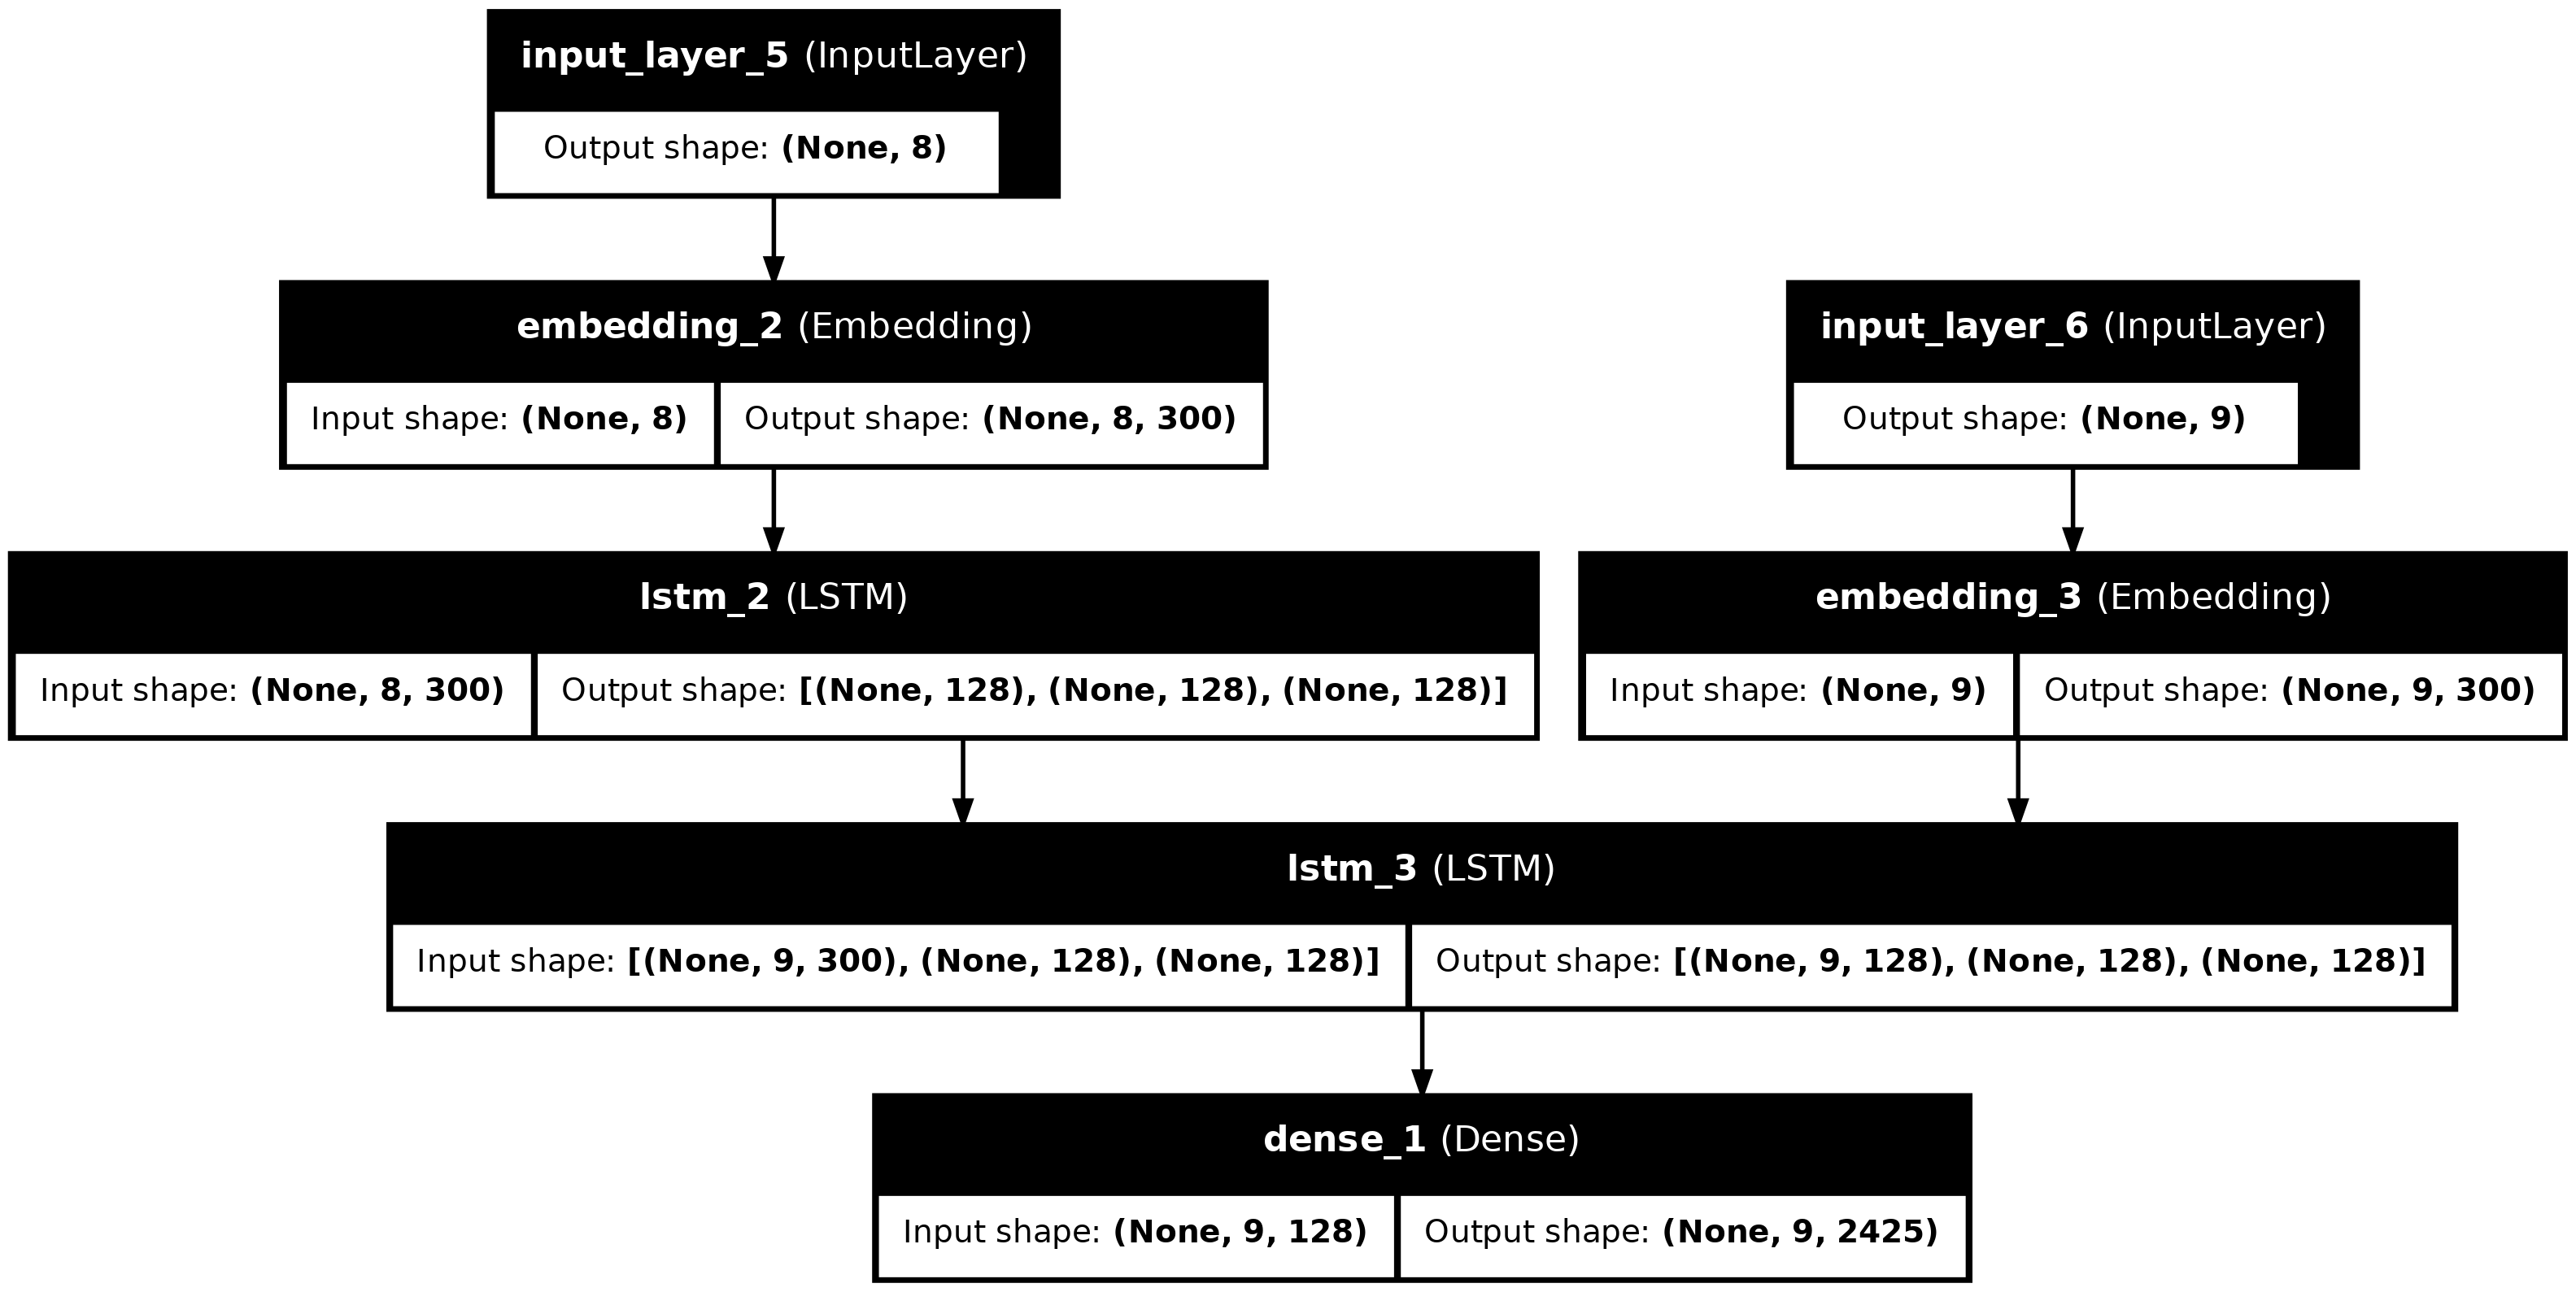

In [22]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Se inicializa el modelo encoder.

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 8, 300)         │       724,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ [(None, 128), (None,   │       219,648 │
│                                 │ 128), (None, 128)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,848 (3.60 MB)

 Trainable params: 219,648 (858.00 KB)

 Non-trainable params: 724,200 (2.76 MB)

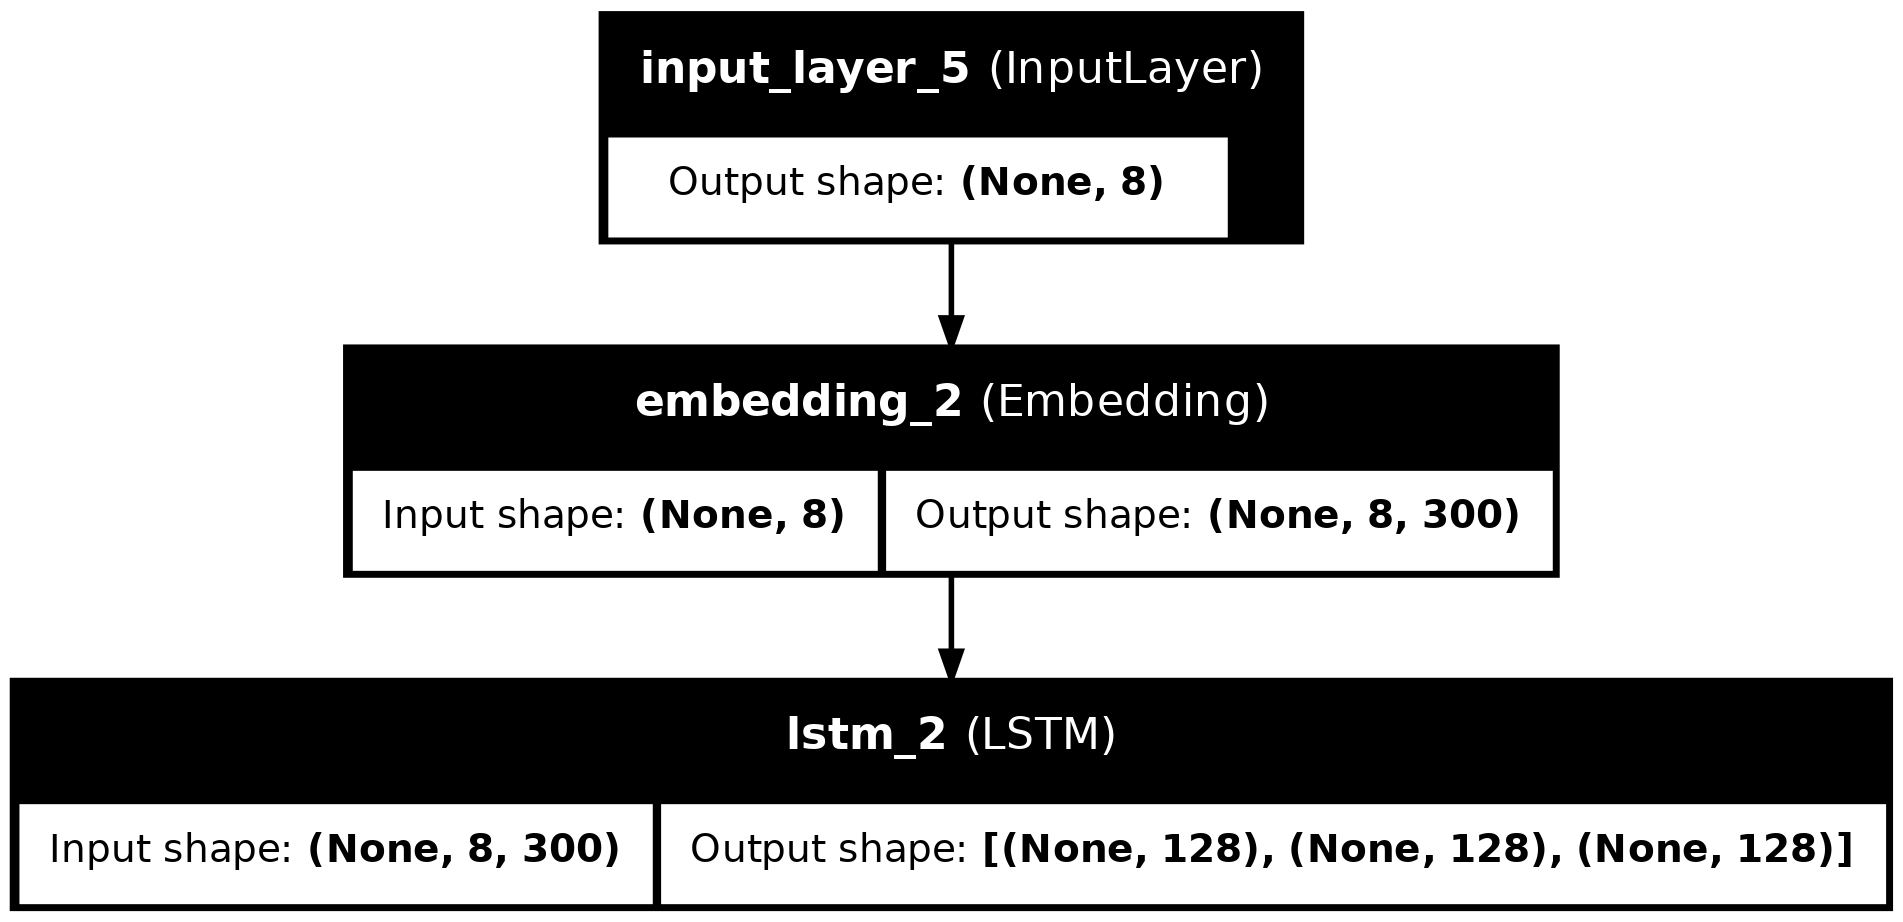

In [23]:
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()
plot_model(encoder_model, to_file='encoder_model_plot.png', show_shapes=True, show_layer_names=True)

Se inicializa el modelo decoder.

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 300)    │    727,500 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 1, 128),  │    219,648 │ embedding_3[1][0… │
│                     │ (None, 128),      │            │ input_layer_7[0]… │
│                     │ (None, 128)]      │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 2425)   │    312,825 │ lstm_3[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,259,973 (4.81 MB)

 Trainable params: 1,259,973 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

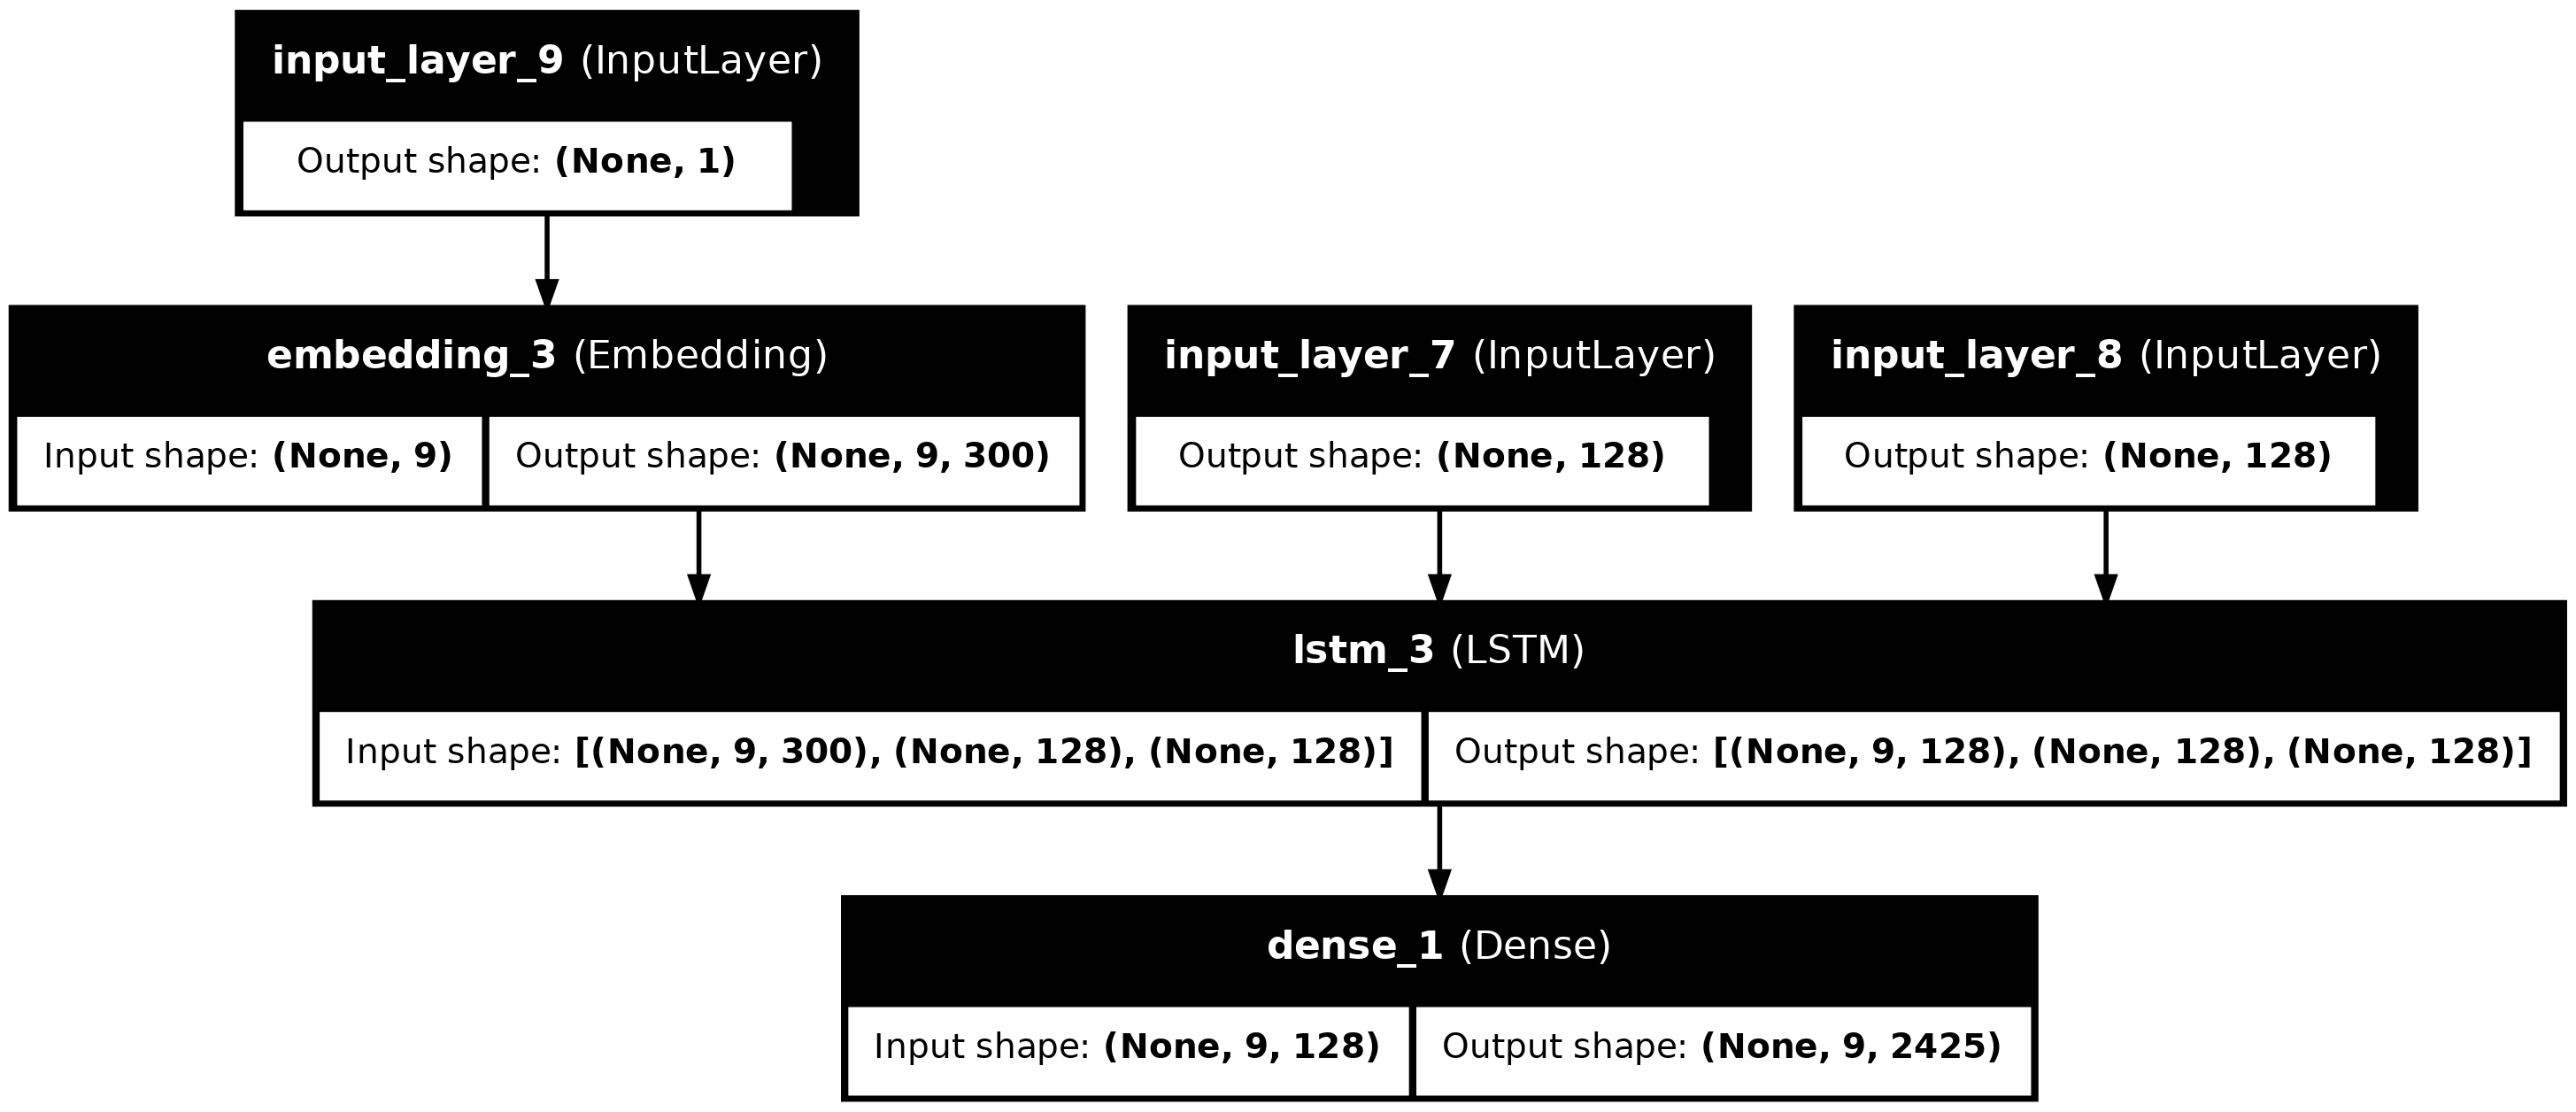

In [24]:
# Define the decoder's state inputs (from the encoder)
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# The decoder will receive one word at a time during inference
decoder_inputs_single = Input(shape=(1,))

# Use the same embedding layer defined during training
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# LSTM for one time step with the previous states
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

# Updated states
decoder_states = [state_h, state_c]

# Dense layer
decoder_outputs = decoder_dense(decoder_outputs)

# Define the decoder inference model
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

decoder_model.summary()
plot_model(decoder_model, to_file='decoder_model_plot.png', show_shapes=True, show_layer_names=True)

Se define el entrenaiento del modelo. Adicionalmente, se consideran los siguientes callbacks: `ModelCheckpoint`, `EarlyStopping` y `ReduceLROnPlateau` en búsqueda de mejorar el modelo e ir guardando los mejores pesos.

In [25]:
# Early stopping to stop training if validation loss does not improve after 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=9, verbose=1)

# Model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint('qa_bot_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Reduce learning rate when the model's performance has plateaued
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Fit the model
history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    batch_size=32,
    epochs=100,
    validation_split=0.25,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
)

# Save the final model if needed (checkpoint will save the best one)
model.save('qa_bot_final_model.keras')

Epoch 1/100
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.5206 - loss: 3.1268
Epoch 1: val_loss improved from inf to 2.04401, saving model to qa_bot_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - categorical_accuracy: 0.5219 - loss: 3.1159 - val_categorical_accuracy: 0.6554 - val_loss: 2.0440 - learning_rate: 0.0100
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.6753 - loss: 1.7357
Epoch 2: val_loss improved from 2.04401 to 1.97177, saving model to qa_bot_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - categorical_accuracy: 0.6753 - loss: 1.7357 - val_categorical_accuracy: 0.6731 - val_loss: 1.9718 - learning_rate: 0.0100
Epoch 3/100
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.6932 - loss: 1.5319
Epoch 3: val_loss improved from 1.97177 to 1.96180, saving model to qa_bot_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - categorical_accuracy: 0.6932 - loss: 1.5320 - val_ca

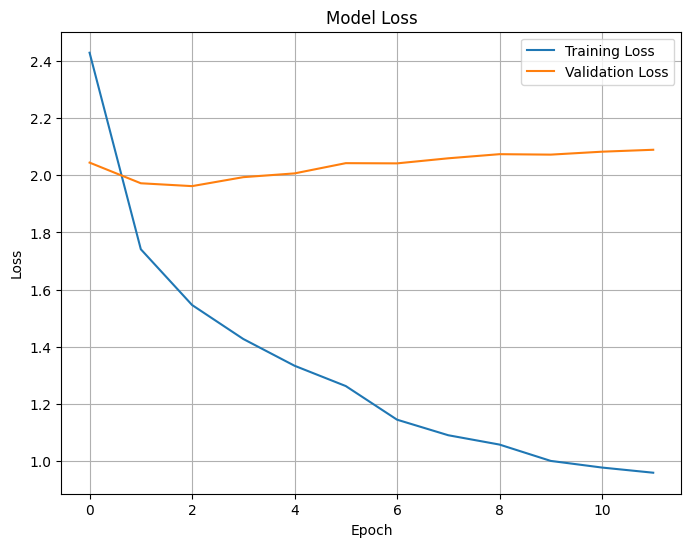

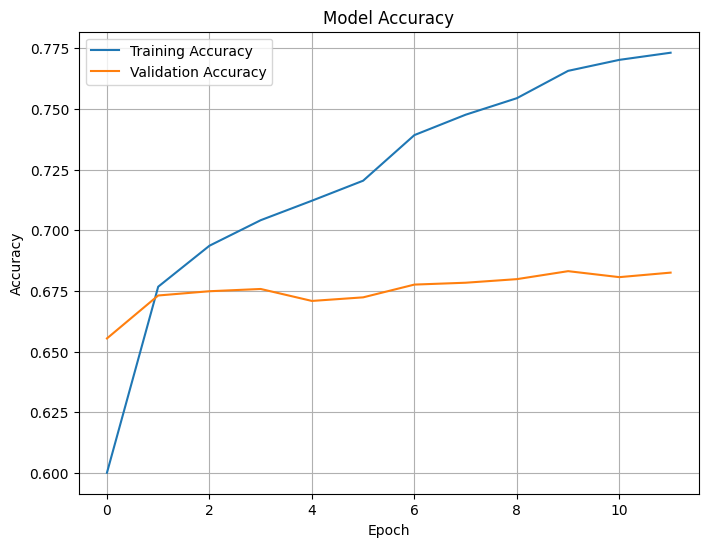

In [26]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Plot training & validation accuracy values (optional if using accuracy as a metric)
if 'categorical_accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

Podemos ver en las gráficas que el modelo se ajusta correctamente y no hay un overfitting muy marcado. Tanto las curvas de pérdida como de precisión convergen al mismo ritmo en el conjunto de entrenamiento y validación.

## Inferencia

Finalmente, se probará la capacidad de inferencia del modelo entrenado. 

In [35]:
idx2word_inputs = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v: k for k, v in word2idx_outputs.items()}

In [52]:
def generate_answer(input_seq):
    """
    Generates an answer for the input sequence using the encoder and decoder models.
    """
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        print("Predicted index:", idx)  # Print the predicted index to debug

        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        states_value = [h, c]
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)


Se prueba con una secuencia de entrada aleatoria y se obtiene la respuesta correspondiente.

In [65]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
answer = generate_answer(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted index: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted index: 27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted index: 2
-
Input: oh i see do you have any hobbies
Response: i love to read


Se puede ver que la respuesta tiene cierto sentido y coherencia con la pregunta realizada.

In [42]:
input_test = "Where are you from?"
input_test_cleaned = clean_text(input_test)
print('Input:', input_test_cleaned)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
print("Representacion en vector de tokens de ids", int_seq_test)
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_input_test)

# Generate the answer
answer = generate_answer(encoder_input_test)
print("Generated Answer:", answer)

Input: where are you from
Representacion en vector de tokens de ids [45, 10, 3, 38]
Padding del vector: [[ 0  0  0  0 45 10  3 38]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted index: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted index: 229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted index: 217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 2
Generated Answer: i am from the united states


En este caso podemos ver que la respuesta obtenida tiene una alta coherencia con la pregunta realizada, lo que indica un buen desempeño del modelo para este caso.

In [43]:
input_test = "Do you read?"
input_test_cleaned = clean_text(input_test)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)

# Generate the answer
answer = generate_answer(encoder_input_test)
print("Generated Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted index: 27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted index: 2
Generated Answer: i love to read


En este caso igualmente, la respuesta obtenida tiene sentido y es coherente con la pregunta realizada. Sin embargo, se puede notar que coincide con la respuesta dada en la primera prueba. Por lo que es posible que el modelo haya memorizado la respuesta, y no haya exactamente aprendido a responder a esta pregunta específica.

In [45]:
input_test = "Do you have any pet?"
input_test_cleaned = clean_text(input_test)
print('Input:', input_test_cleaned)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
print("Representacion en vector de tokens de ids", int_seq_test)
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_input_test)

# Generate the answer
answer = generate_answer(encoder_input_test)
print("Generated Answer:", answer)

Input: do you have any pet
Representacion en vector de tokens de ids [4, 3, 14, 31, 346]
Padding del vector: [[  0   0   0   4   3  14  31 346]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted index: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted index: 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted index: 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted index: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted index: 2
Generated Answer: i am doing well how are you


En este caso el modelo responde con una oración gramaricalmente correcta, además con varias palabras que no se repiten en la pregunta. Sin embargo, la respuesta no tiene sentido con la pregunta realizada.

In [48]:
input_test = "I am John Doe. What do you do?"
input_test_cleaned = clean_text(input_test)
print('Input:', input_test_cleaned)
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
print("Representacion en vector de tokens de ids", int_seq_test)
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_input_test)

# Generate the answer
answer = generate_answer(encoder_input_test)
print("Generated Answer:", answer)

Input: i am john doe what do you do
Representacion en vector de tokens de ids [2, 7, 490, 1, 5, 4, 3, 4]
Padding del vector: [[  2   7 490   1   5   4   3   4]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index: 95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted index: 2
Generated Answer: i am a student
